In [53]:
import os
from pathlib import Path
import numpy as np
import essentia
import essentia.standard as es
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, LogLocator

# %matplotlib notebook
# %matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8) # set plot sizes to something larger than default

Frequency of bin $i$:

\begin{equation}
    f(i) = \frac{i * SR} {2 * N (bins)} 
\end{equation}

In [54]:
def nth_octave_smoothing(spectrum, n: int = 3):
    N = len(spectrum)
    freq_bins = np.linspace(0, int(sample_rate/2), N)
    y = np.zeros(shape=np.shape(spectrum), dtype = type(spectrum[0]))
    M_1 = len(spectrum) - 1

    for k in range(len(spectrum)):
        a = int(np.round(k * 2 ** (-1 /(2 * n))))
        b = int(np.round(k * 2 ** (1 /(2 * n))))

        if a == b:
            b += 1

        if b > M_1:
            b = M_1

        y[k] = (1 / ((b-1) - a + 1)) * np.sum(spectrum[a:b])
    return y, freq_bins

In [55]:
sample_rate = 48000
AUDIO = '/Users/francescopapaleo/src-git/neural-audio-spring-reverb/results/48k/audio/tgt_gcn-250-v30_48k.wav'
FRAME = int(2 ** 10)

[   INFO   ] TriangularBands: input spectrum size (1537) does not correspond to the "inputSize" parameter (1025). Recomputing the filter bank.
[   INFO   ] LogSpectrum: input spectrum size does not match '_frameSize' parameter. Reconfiguring the algorithm.


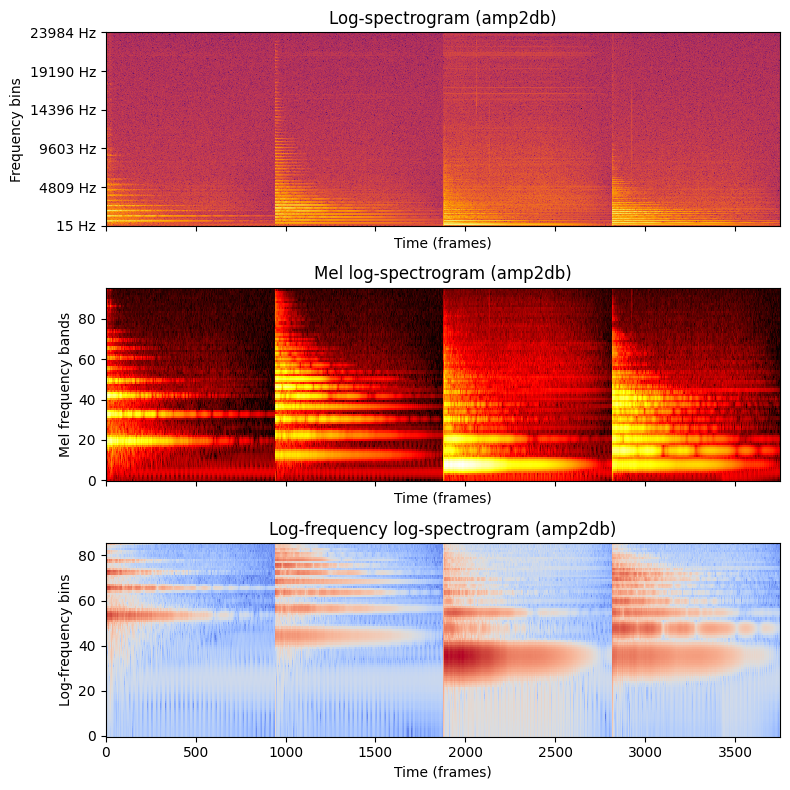

In [56]:
loader = es.MonoLoader(filename=AUDIO, sampleRate=sample_rate)
windowing = es.Windowing(type='blackmanharris62', zeroPadding=2048)
spectrum = es.Spectrum()
melbands = es.MelBands(numberBands=96, lowFrequencyBound=0, highFrequencyBound=11000)
spectrum_logfreq = es.LogSpectrum(binsPerSemitone=1)

amp2db = es.UnaryOperator(type='lin2db', scale=2)
pool = essentia.Pool()

audio = loader()

for frame in es.FrameGenerator(audio, frameSize=FRAME, hopSize=256):
    frame_spectrum = spectrum(windowing(frame))
    frame_mel = melbands(frame_spectrum)
    frame_spectrum_logfreq, _, _ = spectrum_logfreq(frame_spectrum)

    pool.add('spectrum_db', amp2db(frame_spectrum))
    pool.add('mel96_db', amp2db(frame_mel))
    pool.add('spectrum_logfreq_db', amp2db(frame_spectrum_logfreq))

num_bins = len(pool['spectrum_db'][0])

y_ticks = np.linspace(1, num_bins-1, 6)  # Creates 6 ticks
y_ticklabels = [f"{int(i * sample_rate / (2.0 * num_bins))} Hz" for i in y_ticks]

fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, sharex=True, sharey=False)

ax1.set_title("Log-spectrogram (amp2db)")
ax1.set_xlabel("Time (frames)")
ax1.set_ylabel("Frequency bins")
ax1.imshow(pool['spectrum_db'].T, aspect = 'auto', origin='lower', interpolation='none', cmap='inferno')
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_ticklabels)

ax2.set_title("Mel log-spectrogram (amp2db)")
ax2.set_xlabel("Time (frames)")
ax2.set_ylabel("Mel frequency bands")
ax2.imshow(pool['mel96_db'].T, aspect = 'auto', origin='lower', interpolation='none', cmap='hot')

ax3.set_title("Log-frequency log-spectrogram (amp2db)")
ax3.set_xlabel("Time (frames)")
ax3.set_ylabel("Log-frequency bins")
ax3.imshow(pool['spectrum_logfreq_db'].T, aspect = 'auto', origin='lower', interpolation='none', cmap='coolwarm')
# ax3.set_yticks(y_ticks)
# ax3.set_yticklabels(y_ticklabels)

plt.tight_layout()